In [10]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import json
import os
import scipy.signal

from spykshrk.realtime.decoder_process import PointProcessDecoder

import spykshrk.realtime.simulator.nspike_data as nspike_data

from spykshrk.franklab.pp_decoder.pp_clusterless import plot_decode_2d

from spykshrk.franklab.pp_decoder.util import gaussian, normal2D, apply_no_anim_boundary, simplify_pos_pandas

from spykshrk.franklab.pp_decoder.decode_error import bin_pos_data, calc_error_table, \
                                                      plot_arms_error

#pd.set_option('float_format', '{:,.2f}'.format)
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 10)
#pd.set_option('display.width', 180)


idx = pd.IndexSlice


In [8]:
%%time
# Load merged rec HDF store based on config

config_file = '/opt/data36/daliu/realtime/spykshrk/dec_60uv_300samp/bond.config.json'
config = json.load(open(config_file, 'r'))

hdf_file = os.path.join(config['files']['output_dir'],
                        '{}.rec_merged.h5'.format(config['files']['prefix']))

store = pd.HDFStore(hdf_file, mode='r')
spike_decode = store['rec_3']
decoder_df = store['rec_4']
stim_lockout = store['rec_11']

CPU times: user 40 ms, sys: 716 ms, total: 756 ms
Wall time: 753 ms


In [3]:
%%time
stim_lockout_ranges = stim_lockout.pivot(index='lockout_num',columns='lockout_state', values='timestamp')
stim_lockout_ranges = stim_lockout_ranges.reindex(columns=[1,0])


CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.91 ms


In [4]:
%%time
# Get table with decode for each spike and generate decode bin mask

dec_bin_size = 300     # Decode bin size in samples (usually 30kHz)

arm_coordinates = [[0, 69], [150, 150+102], [300, 300+104]]

dec_bins = np.floor((spike_decode['timestamp'] - spike_decode['timestamp'][0])/dec_bin_size).astype('int')
spike_decode['dec_bin'] = dec_bins


pos_upper = config['encoder']['position']['upper']
pos_lower = config['encoder']['position']['lower']
pos_num_bins = config['encoder']['position']['bins']
pos_bin_delta = ((pos_upper - pos_lower) / pos_num_bins)

x_bins = np.linspace(0, pos_bin_delta*(pos_num_bins-1), pos_num_bins)
x_bin_edges = np.linspace(0, pos_bin_delta*(pos_num_bins), pos_num_bins+1)

pos_kernel = gaussian(x_bins, x_bins[int(len(x_bins)/2)], 3)


CPU times: user 20 ms, sys: 16 ms, total: 36 ms
Wall time: 25.2 ms


In [5]:
# Get real position

nspike_anim = nspike_data.AnimalInfo(**config['simulator']['nspike_animal_info'])
pos = nspike_data.PosMatDataStream(nspike_anim)
pos_data = pos.data

# Transform position into simpler table with only linear position
pos_data_linpos = simplify_pos_pandas(pos_data)

# Convert real pos to realtime system linear map (single linear coordinate)

center_pos_flat = pos_data_linpos[pos_data_linpos['seg_idx'] == 1]['well_center']
left_pos_flat = pos_data_linpos[(pos_data_linpos['seg_idx'] == 2) | 
                                (pos_data_linpos['seg_idx'] == 3)]['well_left'] + 150
right_pos_flat = pos_data_linpos[(pos_data_linpos['seg_idx'] == 4) | 
                                 (pos_data_linpos['seg_idx'] == 5)]['well_right'] + 300

center_pos_flat.name = 'linpos_flat'
left_pos_flat.name = 'linpos_flat'
right_pos_flat.name = 'linpos_flat'

linpos_flat = pd.concat([center_pos_flat, left_pos_flat, right_pos_flat])
linpos_flat = linpos_flat.sort_index()

PosMatData: INIT start
/opt/data/daliu/other/mkarlsso/Bon
['/opt/data/daliu/other/mkarlsso/Bon/bonlinpos04.mat']
[(4, '/opt/data/daliu/other/mkarlsso/Bon/bonlinpos04.mat')]
PosMatData: INIT done


/home/daliu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/daliu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [7]:
%%time
# Run spykshrk.realtime version of point process decoding

pp_decoder = PointProcessDecoder(pos_range=[config['encoder']['position']['lower'],
                                            config['encoder']['position']['upper']],
                                 pos_bins=config['encoder']['position']['bins'],
                                 time_bin_size=config['pp_decoder']['bin_size'],
                                 arm_coor=config['pp_decoder']['arm_pos'],
                                 uniform_gain=config['pp_decoder']['trans_mat_uniform_gain'])

pp_decoder.select_ntrodes(config['simulator']['nspike_animal_info']['tetrodes'])

num_time_bins = spike_decode.loc[:,'dec_bin'].max()

groups = spike_decode.groupby('dec_bin')

last_bin_id = 0

spykshrk_posteriors = np.zeros([num_time_bins+1, pos_num_bins])

for bin_id, spikes_in_bin in groups:
    if last_bin_id <= bin_id - 1:
        for bin_no_spk_id in range(last_bin_id + 1, bin_id):
            post = pp_decoder.increment_no_spike_bin()
            spykshrk_posteriors[bin_no_spk_id, :] = post
        
    for ntrode_id, dec in zip(spikes_in_bin.loc[:, 'ntrode_id'].values, 
                   spikes_in_bin.loc[:, 'x0': 'x{:d}'.format(pos_num_bins-1)].values):
        pp_decoder.add_observation(ntrode_id, dec)
        
    post = pp_decoder.increment_bin()
    spykshrk_posteriors[bin_id, :] = post
    last_bin_id = bin_id
    

/home/daliu/Src/spykshrk_realtime/spykshrk/realtime/decoder_process.py:100: RuntimeWarning: invalid value encountered in true_divide
  transition_mat = transition_mat/(transition_mat.sum(axis=0)[None, :])
/home/daliu/Src/spykshrk_realtime/spykshrk/realtime/decoder_process.py:104: RuntimeWarning: invalid value encountered in true_divide
  uniform_dist = uniform_dist/(uniform_dist.sum(axis=0)[None, :])


CPU times: user 1min 21s, sys: 616 ms, total: 1min 21s
Wall time: 1min 21s


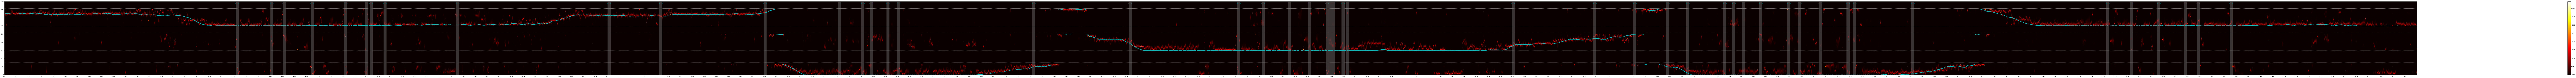

In [11]:
plt_ranges = [[2461, 3404]]
plt_ranges = [[2461 + 700, 2461+900]]

for plt_range in plt_ranges:
    plt.figure(figsize=(400,10))
    plot_decode_2d(decoder_df.loc[:,'x0':'x449'].values,
                   decoder_df['timestamp'], stim_lockout_ranges, 
                   decoder_df.set_index('real_pos_time')['real_pos'], plt_range, 1.0)
plt.show()